## MNIST Image Classification with an RNN Model

### Build the dataset and dataloader

In [15]:
import torch
import torchvision
from torchvision import transforms

# Define the transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create the data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Visualize samples from the dataset

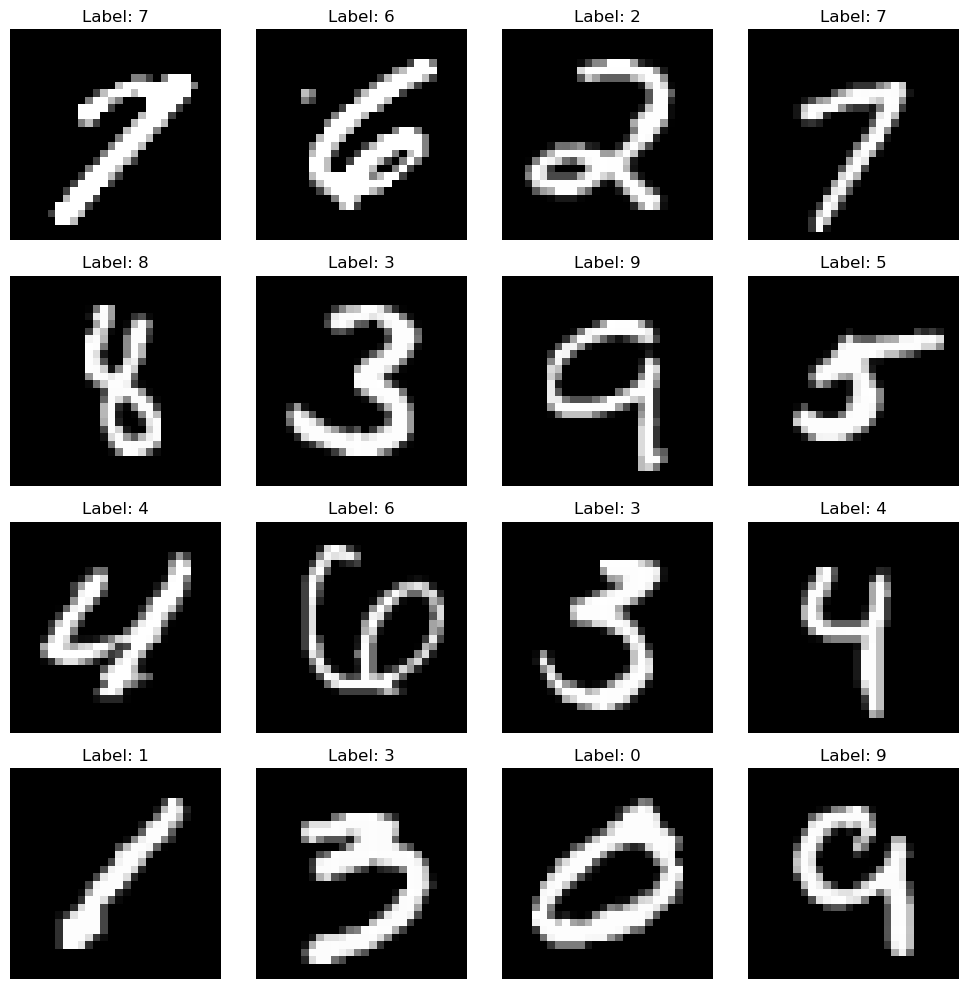

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Get 16 random indices
indices = np.random.choice(len(train_dataset), size=16, replace=False)

# Get the corresponding images and labels
images = [train_dataset[i][0] for i in indices]
labels = [train_dataset[i][1] for i in indices]

# Create a figure with 4x4 subplots
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Iterate over the subplots and display the images with labels
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


### Build the RNN Model

In [39]:
import torch
import torch.nn as nn
import math

class ParameterModel(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128, num_classes=10):
        super(ParameterModel, self).__init__()
        self.fc1 = nn.parameter.Parameter(torch.randn(input_size, hidden_size))   
        nn.init.kaiming_uniform_(self.fc1, a=math.sqrt(5))
        self.bias1 = nn.parameter.Parameter(torch.randn(hidden_size))
        self.reset_bias(self.fc1, self.bias1)
        self.relu = nn.ReLU()
        self.fc2 = nn.parameter.Parameter(torch.randn(hidden_size, num_classes))
        nn.init.kaiming_uniform_(self.fc2, a=math.sqrt(5))
        self.bias2 = nn.parameter.Parameter(torch.randn(num_classes))
        self.reset_bias(self.fc2, self.bias2)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.einsum('bi,ij->bj', (x, self.fc1)) + self.bias1
        x = self.relu(x)
        x = torch.einsum('bi,ij->bj', (x, self.fc2)) + self.bias2
        return x
    
    def reset_bias(self, weight, bias):
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(weight)
        bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
        nn.init.uniform_(bias, -bound, bound)
        return bias

x = torch.randn(64, 1, 28, 28)
model = ParameterModel()
print(model)
print(model(x).shape)

# print the number of parameters
num_params = sum(p.numel() for p in model.parameters())
# Use comma to print the number in a more readable format
print(f"Number of parameters: {num_params:,}")

tensor(-0.1020, grad_fn=<SelectBackward0>)
tensor(-0.0569, grad_fn=<SelectBackward0>)
ParameterModel(
  (relu): ReLU()
)
torch.Size([64, 10])
Number of parameters: 101,770


### Define the loss function and optimizer

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model

In [41]:
from tqdm import tqdm

num_epochs = 10

model.train()
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")


 10%|█         | 1/10 [00:08<01:18,  8.73s/it]

Epoch: 1, Loss: 0.3476


 20%|██        | 2/10 [00:17<01:09,  8.64s/it]

Epoch: 2, Loss: 0.1807


 30%|███       | 3/10 [00:25<01:00,  8.60s/it]

Epoch: 3, Loss: 0.1366


 40%|████      | 4/10 [00:34<00:51,  8.57s/it]

Epoch: 4, Loss: 0.1156


 50%|█████     | 5/10 [00:43<00:43,  8.65s/it]

Epoch: 5, Loss: 0.1010


 60%|██████    | 6/10 [00:51<00:34,  8.61s/it]

Epoch: 6, Loss: 0.0884


 70%|███████   | 7/10 [01:00<00:25,  8.59s/it]

Epoch: 7, Loss: 0.0801


 80%|████████  | 8/10 [01:08<00:17,  8.58s/it]

Epoch: 8, Loss: 0.0740


 90%|█████████ | 9/10 [01:17<00:08,  8.63s/it]

Epoch: 9, Loss: 0.0676


100%|██████████| 10/10 [01:26<00:00,  8.61s/it]

Epoch: 10, Loss: 0.0634


### Evaluate the model

In [42]:
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9728


### Predict on sample images

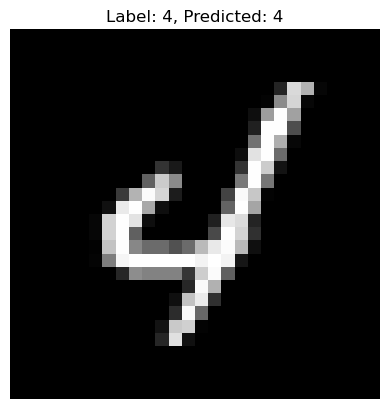

In [43]:
import random

# Set the model to evaluation mode
model.eval()

# Select a random image from the test dataset
random_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_index]

# Move the image to the device
image = image.to(device)

# Forward pass to get the predicted label
output = model(image.unsqueeze(0))
_, predicted_label = torch.max(output, 1)

# Convert the image tensor to a numpy array
image_np = image.cpu().numpy()

# Display the image, its label, and the predicted label
plt.imshow(image_np.squeeze(), cmap='gray')
plt.title(f"Label: {label}, Predicted: {predicted_label.item()}")
plt.axis('off')
plt.show()
